In [1]:
import scipy.stats as stats
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import sys
import corner
import pystan
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd

np.random.seed(1234)

In [2]:
# The aim of this practical is to construct and constrain a Bayesian hierarchical model for the 
# distribution of masses of black holes, based on LIGO O1 and O2 observations. To describe the 
# gravitational wave measurements we will use the posterior distribution on the chirp mass and
# symmetric mass ratio. The median and 90% symmetric credible intervals for the events in the 
# GWTC-1 paper were as follows. Entries are written in the form 
#      GWXXX: [Mc_low, Mc_med, Mc_high]   [eta_low, eta_med, eta_high]
# where Mc_low, Mc_med and Mc_high are, respectively, the lower edge of the 90% credible interval, 
# the median and the upper edge of the 90% credible interval for the chirp mass, and eta_low, 
# eta_med, eta_high are the corresponding quantities for the symmetric mass ratio.

# GW150914: [27.1, 28.6, 30.3] [0.2397, 0.2487, 0.2500] 
# GW151012: [14.0, 15.2, 17.3] [0.1547, 0.2334, 0.2498] 
# GW151226: [8.6, 8.9, 9.2] [0.1514, 0.2301, 0.2498] 
# GW170104: [19.6, 21.4, 23.6] [0.2082, 0.2386, 0.2498] 
# GW170608: [7.7, 7.9, 8.1] [0.1870, 0.2417, 0.2499] 
# GW170729: [30.6, 35.4, 41.9] [0.2030, 0.2408, 0.2499]
# GW170809: [23.2, 24.9, 27.0] [0.2122, 0.2409, 0.2499] 
# GW170814: [23.0, 24.1, 25.5] [0.2339, 0.2478, 0.2500] 
# GW170818: [24.8, 26.5, 28.6] [0.2241, 0.2453, 0.2499] 
# GW170823: [25.6, 29.2, 33.8] [0.2130, 0.2446, 0.2499] 

# To aid computation we will approximate these posterior distributions. The chirp mass posteriors 
# will be approximated by a Gaussian, with mean equal to Mc_med and standard deviation equal to 
# (Mc_high-Mc_low)/3.29. For the symmetric mass ratio posteriors, we will use a B(a,1) distribution
# approximation for 4*eta. As can be seen from the Table above, the eta posteriors are not Gaussian, 
# but peak at the upper end of the allowed range, near eta = 0.25. A Beta(a,1) distribution has a 
# similar form, on the interval [0,1], which is why we represent the distribution in this way. For
# B(a,1), the median value satisfies x^a = 0.5 and the lower 5% point satisfies x^a = 0.05. Hence 
# we can choose a based on the median value or the lower end of the 90% credible interval, for the 
# median the formula is a = ln(1/2)/(ln(4*eta_med)). We'll try both below.

Mc_low=np.array([27.1,14.0,8.6,19.6,7.7,30.6,23.2,23.0,24.8,25.6])
Mc_med=np.array([28.6,15.2,8.9,21.4,7.9,35.4,24.9,24.1,26.5,29.2])
Mc_high=np.array([30.3,17.3,9.2,23.6,8.1,41.9,27.0,25.5,28.6,33.8])
eta_low=np.array([0.2397,0.1547,0.1514,0.2082,0.187,0.203,0.2122,0.2339,0.2241,0.213])
eta_med=np.array([0.2487,0.2334,0.2301,0.2386,0.2417,0.2408,0.2409,0.2478,0.2453,0.2446])
eta_high=np.array([0.25,0.2499,0.2498,0.2498,0.2499,0.2499,0.2499,0.25,0.2499,0.2499])

mc_mean=Mc_med
mc_std=(Mc_high-Mc_low)/3.29
eta_a=np.log(0.5)/(np.log(4.0*eta_med))
eta_a_alt=np.log(0.05)/(np.log(4.0*eta_low))

In [4]:
# Check the median value corresponding to the a value determined from the lower limit of the eta credible 
# interval and vice versa. The match to the true posterior values is not great, suggesitng the Beta distribution 
# is not a fantastic fit, but we will proceed anyway since we want an analytic form for the distribution.

eta_low_mod=0.25*(0.05**(1.0/eta_a))
eta_low_mod_alt=0.25*(0.05**(1.0/eta_a_alt))
eta_med_mod=0.25*(0.5**(1.0/eta_a))
eta_med_mod_alt=0.25*(0.5**(1.0/eta_a_alt))
print(eta_low_mod)
print(eta_med_mod)

[0.24442983 0.18577074 0.17468254 0.204332   0.21605585 0.21260025
 0.2129821  0.24062979 0.23031206 0.227485  ]
[0.2487 0.2334 0.2301 0.2386 0.2417 0.2408 0.2409 0.2478 0.2453 0.2446]


In [5]:
# The likelihood of the observed data will be modelled for each event as a product of a beta distribution for
# eta and a Gaussian for the chirp mass. We want to constrain the population by using a hierarchical model. 
# First we take a simple truncated power law (model A/B in the GWTC-1 companion paper).
#
#          p(m1, m2 | mmin, mmax, alpha, beta) = C(m1) m1^(-alpha) (m2/m1)^beta for mmin <= m2 <= m1 <= mmax
#
# The function C(m1) is chosen to ensure that the marginal prior on m1 is a power law m1^(-alpha). We first take
# the simplest model, model A, in which we fix mmin=5 and beta = 0, for which C(m1) = (m1-mmin).

# The final quantity we need is the selection function. As discussed in lectures, gravitational wave detectors 
# are not infinitely sensitive, and only events that are sufficiently loud are detected and used to constrain 
# the population. To incorporate selection effects we must renormalise the likelihood by dividing by the 
# integral over the population model of the probability of detection. We approximate the latter as proportional 
# to m1^2.2 (see Fishbach & Holz for justification of this approximation). The selection function is therefore
#
#           p(D|mmin,mmax,alpha,beta) \propto int_mmin^mmax m1^(2.2-alpha)
#                                     \propto mmax^(3.2-alpha)-mmin^(3.2-alpha)
#

# Exercises

In [6]:
# 1) Write a pystan model that represents the hierarchical model described above.
#
# 2) Obtain the posterior distribution for model A using pystan. Compute also the posterior predictive 
#    distribution for m1 based on these results.
#
# 3) Adapt your model to fit model B from the GWTC-1 companion paper, in which all four parameters of the power
#    law are allowed to vary.
# 
# 4) How would you need to change the model to fit model C from the GWTC-1 companion paper, which includes both
#    a power law and a Gaussian component?

In [7]:
# 1) Write a pystan model that represents the hierarchical model described above.

gwtc_astropop_modelA_def = """
data {
  int nobs;
  real mmin;
  real mcmean[nobs];
  real mcstd[nobs];
  real eta_a[nobs];
}

parameters {
  real<lower=0,upper=1> m1true[nobs];
  real<lower=0,upper=1> m2true[nobs];
  real<lower=-4.0,upper=12.0> alpha;
  real<lower=30.0,upper=100.0> mmax;
}

model {
  real m1val;
  real m2val;
  real mcval;
  real etaval;
  for (i in 1:nobs) {
        m1val=mmin+m1true[i]*(mmax-mmin);
        m2val=mmin+m2true[i]*(m1val-mmin);
        mcval=pow(m1val*m2val,0.6)/pow(m1val+m2val,0.2);
        etaval=m1val*m2val/pow(m1val+m2val,2);
        target+=normal_lpdf(mcval | mcmean[i], mcstd[i]);
        target+=beta_lpdf(4.0*etaval|eta_a[i],1);
        target+=-1.0*(alpha*log(m1val)+log(m1val-mmin));
  }
  target+=-1.0*nobs*log((pow(mmax,3.2-alpha)-pow(mmin,3.2-alpha))/(3.2-alpha));
}

generated quantities {
  real m1pred;
  real m2pred;
  vector[nobs] m1val;
  vector[nobs] m2val;
  vector[nobs] mcval;
  vector[nobs] etaval;
  for (i in 1:nobs) {
    m1val[i]=mmin+m1true[i]*(mmax-mmin);
    m2val[i]=mmin+m2true[i]*(m1val[i]-mmin);
    mcval[i]=pow(m1val[i]*m2val[i],0.6)/pow(m1val[i]+m2val[i],0.2);
    etaval[i]=m1val[i]*m2val[i]/pow(m1val[i]+m2val[i],2);
  }
  m1pred=pow(pow(mmin,1.0-alpha)-uniform_rng(0,1)*(pow(mmin,1.0-alpha)-pow(mmax,1.0-alpha)),1.0/(1.0-alpha));
  m2pred=mmin+uniform_rng(0,1)*(m1pred-mmin);

}

"""
gwtc_astropop_modelA = pystan.StanModel(model_code=gwtc_astropop_modelA_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3398f1565fff0096abf4c91a6438cd7d NOW.


Inference for Stan model: anon_model_3398f1565fff0096abf4c91a6438cd7d.
4 chains, each with iter=10000; warmup=250; thin=1; 
post-warmup draws per chain=9750, total post-warmup draws=39000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m1true[1]    0.92  5.4e-4   0.06   0.76   0.88   0.93   0.97    1.0  14471    1.0
m1true[2]     0.5  1.0e-3   0.12   0.33   0.42   0.47   0.56   0.82  14334    1.0
m1true[3]    0.23  5.2e-4   0.07   0.15   0.18   0.21   0.25   0.41  16073    1.0
m1true[4]    0.71  8.2e-4   0.11   0.53   0.64    0.7   0.78   0.94  16430    1.0
m1true[5]    0.17  3.4e-4   0.04   0.12   0.14   0.16   0.19   0.29  16411    1.0
m1true[6]    0.93  2.8e-4   0.06   0.78   0.91   0.95   0.98    1.0  45085    1.0
m1true[7]    0.83  7.0e-4   0.09   0.65   0.77   0.83   0.89   0.99  16214    1.0
m1true[8]    0.79  7.3e-4   0.08   0.62   0.73   0.78   0.84   0.96  13369    1.0
m1true[9]    0.87  6.3e-4   0.08    0.7   0.82   0.87   0.93   0.99  160

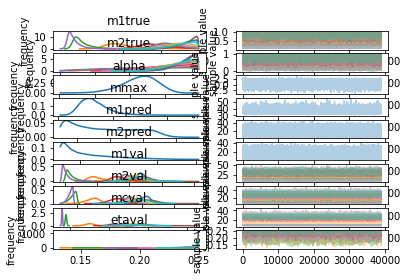

In [8]:
# 2) Obtain the posterior distribution for model A using pystan. Compute also the posterior predictive 
#    distribution for m1 based on these results.

# Define data array
nobs=10
mmin=5.0

gwtc_astropop_modelA_data = {'nobs': nobs,
            'mmin': mmin,
            'mcmean': mc_mean[:],
            'mcstd': mc_std[:], 'eta_a': eta_a_alt[:]}
          
# Now get some samples from the posterior
gwtc_astropop_modelA_fit = gwtc_astropop_modelA.sampling(data=gwtc_astropop_modelA_data, iter=10000, chains=4, warmup=250, thin=1, seed=101)

# Plot results 
gwtc_astropop_modelA_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
gwtc_astropop_modelA_fit

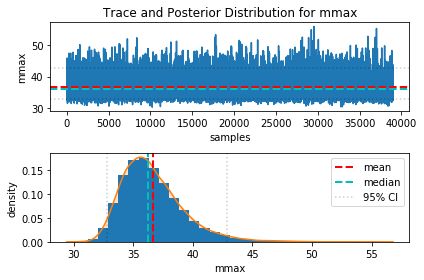

In [9]:
summary_dict = gwtc_astropop_modelA_fit.summary()
gwtc_astropop_modelA_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='mmax'

cred_min, cred_max = np.percentile(gwtc_astropop_modelA_fit[param], 2.5), np.percentile(gwtc_astropop_modelA_fit[param], 97.5)
mean=np.mean(gwtc_astropop_modelA_fit[param])
median=np.median(gwtc_astropop_modelA_fit[param])

plt.subplot(2,1,1)
plt.plot(gwtc_astropop_modelA_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(gwtc_astropop_modelA_fit[param], 30, density=True); sns.kdeplot(gwtc_astropop_modelA_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()



In [136]:
# 3) Adapt your model to fit model B from the GWTC-1 companion paper, in which all four parameters of the power
#    law are allowed to vary.

gwtc_astropop_modelB_def = """
data {
  int nobs;
  real mcmean[nobs];
  real mcstd[nobs];
  real eta_a[nobs];
}

parameters {
  real<lower=0,upper=1> m1true[nobs];
  real<lower=0,upper=1> m2true[nobs];
  real<lower=-4.0,upper=12.0> alpha;
  real<lower=30.0,upper=100.0> mmax;
  real<lower=5.0,upper=10.0> mmin;
  real<lower=-4.0,upper=12.0> beta;
}

model {
  real m1val;
  real m2val;
  real mcval;
  real etaval;
  for (i in 1:nobs) {
        m1val=mmin+m1true[i]*(mmax-mmin);
        m2val=mmin+m2true[i]*(m1val-mmin);
        mcval=pow(m1val*m2val,0.6)/pow(m1val+m2val,0.2);
        etaval=m1val*m2val/pow(m1val+m2val,2);
        target+=normal_lpdf(mcval | mcmean[i], mcstd[i]);
        target+=beta_lpdf(4.0*etaval|eta_a[i],1);
        target+=-1.0*(alpha*log(m1val)+log(pow(m1val,beta+1.0)-pow(mmin,beta+1.0))-beta*log(m2val));
        target+=log(beta+1.0);
  }
  target+=-1.0*nobs*log((pow(mmax,3.2-alpha)-pow(mmin,3.2-alpha))/(3.2-alpha));
}

generated quantities {
  real m1pred;
  real m2pred;
  vector[nobs] m1val;
  vector[nobs] m2val;
  vector[nobs] mcval;
  vector[nobs] etaval;
  for (i in 1:nobs) {
    m1val[i]=mmin+m1true[i]*(mmax-mmin);
    m2val[i]=mmin+m2true[i]*(m1val[i]-mmin);
    mcval[i]=pow(m1val[i]*m2val[i],0.6)/pow(m1val[i]+m2val[i],0.2);
    etaval[i]=m1val[i]*m2val[i]/pow(m1val[i]+m2val[i],2);
  }
  m1pred=pow(pow(mmin,1.0-alpha)-uniform_rng(0,1)*(pow(mmin,1.0-alpha)-pow(mmax,1.0-alpha)),1.0/(1.0-alpha));
  m2pred=mmin+uniform_rng(0,1)*(m1pred-mmin);

}

"""
gwtc_astropop_modelB = pystan.StanModel(model_code=gwtc_astropop_modelB_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa429d11b9414b5c9f3ffe43436bad94 NOW.


Inference for Stan model: anon_model_fa429d11b9414b5c9f3ffe43436bad94.
10 chains, each with iter=10000; warmup=250; thin=1; 
post-warmup draws per chain=9750, total post-warmup draws=97500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m1true[1]    0.85    0.04   0.09   0.69   0.75   0.88   0.93   0.99      6    2.5
m1true[2]    0.33    0.02   0.06   0.25   0.28   0.31   0.36   0.43      8   1.66
m1true[3]    0.05  5.1e-3   0.01   0.02   0.05   0.05   0.06   0.08      8   1.61
m1true[4]    0.57    0.03   0.08   0.44   0.54   0.57   0.61   0.73      7   1.79
m1true[5]  3.7e-4     nan 2.8e-36.4e-13 6.8e-9 2.0e-8 2.4e-6 3.4e-3    nan   1.03
m1true[6]    0.88    0.04    0.1    0.7   0.81    0.9   0.98   0.99      6   2.65
m1true[7]    0.73    0.05   0.12   0.49   0.69   0.72   0.78   0.92      6   2.39
m1true[8]     0.7    0.03   0.09   0.52   0.66    0.7   0.74   0.84      6   2.12
m1true[9]    0.77    0.04   0.09   0.56   0.75   0.78    0.8   0.96    

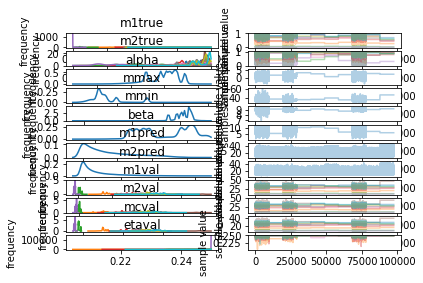

In [144]:
nobs=10

gwtc_astropop_modelB_data = {'nobs': nobs,
            'mcmean': mc_mean[:],
            'mcstd': mc_std[:], 'eta_a': eta_a_alt[:]}
          
# Now get some samples from the posterior
#gwtc_astropop_modelB_fit = gwtc_astropop_modelB.sampling(data=gwtc_astropop_modelB_data, iter=10000, chains=4, warmup=250, thin=1, seed=101)
#gwtc_astropop_modelB_fit = gwtc_astropop_modelB.sampling(data=gwtc_astropop_modelB_data, iter=10000, chains=1, init=[initcond], warmup=250, thin=1, seed=101)
gwtc_astropop_modelB_fit = gwtc_astropop_modelB.sampling(data=gwtc_astropop_modelB_data, iter=10000, chains=10, warmup=250, thin=1, seed=101)



# Plot results 
gwtc_astropop_modelB_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
gwtc_astropop_modelB_fit

The convergence statistics above don't look very good. However, we see that some of the chains (3 of them in this case) are mixing well and others are stuck. The problem here is that there are two events (GW151226 and expecially GW170608) have very low mass. For high values of mmin within the prior range the observed values of these events lie very far in the tail of the distribution, leading to extremely low initial likelihoods. Chains that start in these parts of parameter space cannot move around. The solution is to extract the samples from the 3 well mixed chains and use those to generate the posterior plots. We do this in the following section.

In [145]:
summary_dict = gwtc_astropop_modelB_fit.summary()
gwtc_astropop_modelB_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
samplist=np.arange(0,9750)
samplist=np.append(samplist,np.arange(19500,29250))
samplist=np.append(samplist,np.arange(68250,78000))

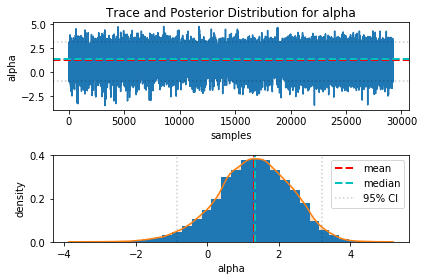

In [152]:
# Plot trace plot and histogram of posterior samples for parameter 'param'
param='alpha'
plotsamps=gwtc_astropop_modelB_fit[param][samplist]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

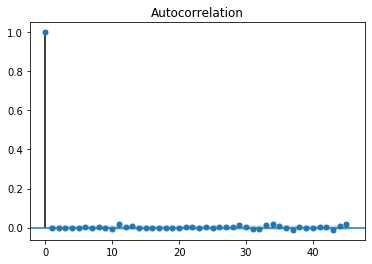

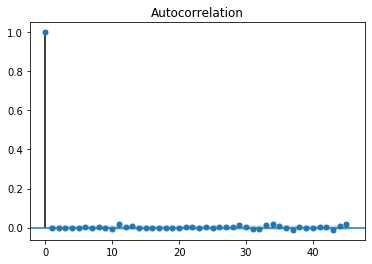

In [153]:
# Check that these samples are indeed good samples from the posterior by computing the auto-correlation function.
plot_acf(plotsamps)

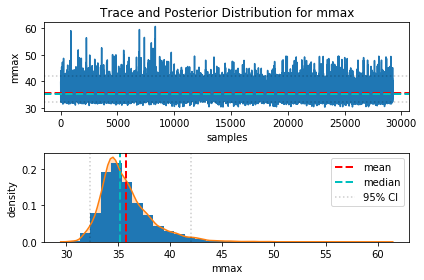

In [147]:
param='mmax'
plotsamps=gwtc_astropop_modelB_fit[param][samplist]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

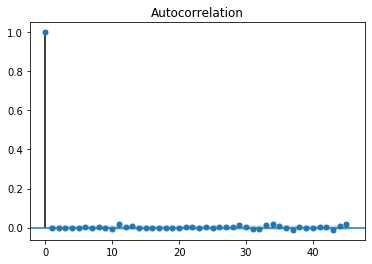

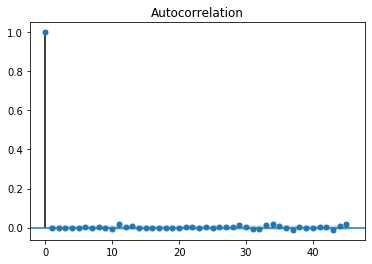

In [154]:
# Same check of samples
plot_acf(plotsamps)

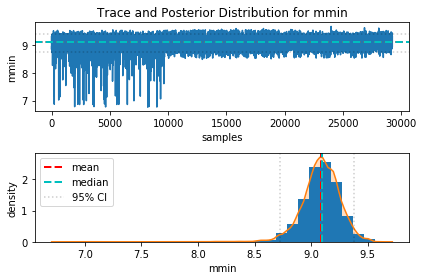

In [148]:
param='mmin'
plotsamps=gwtc_astropop_modelB_fit[param][samplist]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

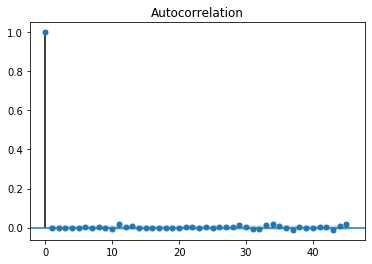

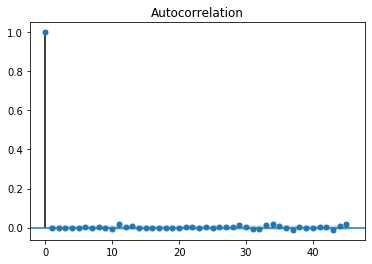

In [155]:
# Same check of samples
plot_acf(plotsamps)

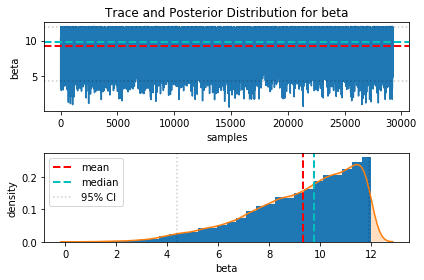

In [149]:
param='beta'
plotsamps=gwtc_astropop_modelB_fit[param][samplist]

cred_min, cred_max = np.percentile(plotsamps, 2.5), np.percentile(plotsamps, 97.5)
mean=np.mean(plotsamps)
median=np.median(plotsamps)

plt.subplot(2,1,1)
plt.plot(plotsamps)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotsamps, 30, density=True); sns.kdeplot(plotsamps, shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()

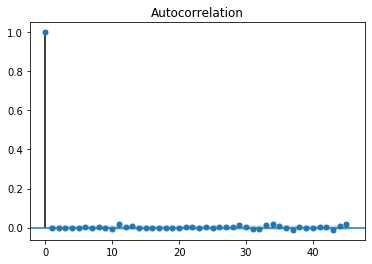

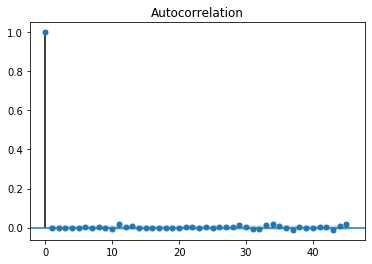

In [156]:
# Same check of samples
plot_acf(plotsamps)

We see that we favour beta at the upper end of the prior range, but measure alpha to be about 1.5, mmin to be approximately 9 and mmax to be approximately 35. These results are reasonably consistent with what was found using the actual LIGO observations. The LIGO posterior for beta was not quite rthe same as the one we get here, since while it did rise toward beta = 12, it flattened and was approximately flat between beta = 6 and beta = 12. Nonetheless, since this entire analysis was done using quantities eyeballed from the LIGO papers, the result is remarkably good.